## Анализ временных рядов

Для анализа временных рядов был выбран набор данных, включающий стоимость муки. Данные охватывают период с января 2009 года по декабрь 2020 года. Источником данных является Росстат. Цель работы — анализ временных рядов методом Бокса-Дженкинса и построение прогноза с использованием моделей ARIMA. Анализ включает коррелограммы, выбор параметров моделей и тестирование.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima import auto_arima
import statsmodels.tsa.stattools as smts_stats
from statsmodels.stats.diagnostic import acorr_ljungbox

In [5]:
# pip install pmdarima

In [6]:
# pip install arch

In [7]:
# pip install --upgrade statsmodels

In [8]:
file_path = 'econ.xlsx'
data = pd.read_excel(file_path)

In [9]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [10]:
data.set_index('Date',inplace=True, drop=False)

In [11]:
data

,Date,Export tonna,Export dollar,Price,Muka,Makar
Date,,,,,,
2009-01-01,2009-01-01,855749.2,143578.6,4323.94,21.34,45.52
2009-02-01,2009-02-01,1114497.3,191983.7,4350.20,21.49,45.97
2009-03-01,2009-03-01,1760749.0,300488.1,4452.86,21.54,47.09
2009-04-01,2009-04-01,1480554.6,232038.3,4453.28,21.39,47.48
2009-05-01,2009-05-01,1050652.9,172064.8,4424.73,21.16,47.51
...,...,...,...,...,...,...
2020-08-01,2020-08-01,4643184.0,913048.7,11474.87,39.88,80.44
2020-09-01,2020-09-01,4998534.1,985410.2,11571.13,39.94,80.70
2020-10-01,2020-10-01,4431840.2,921741.3,12294.68,40.27,80.78


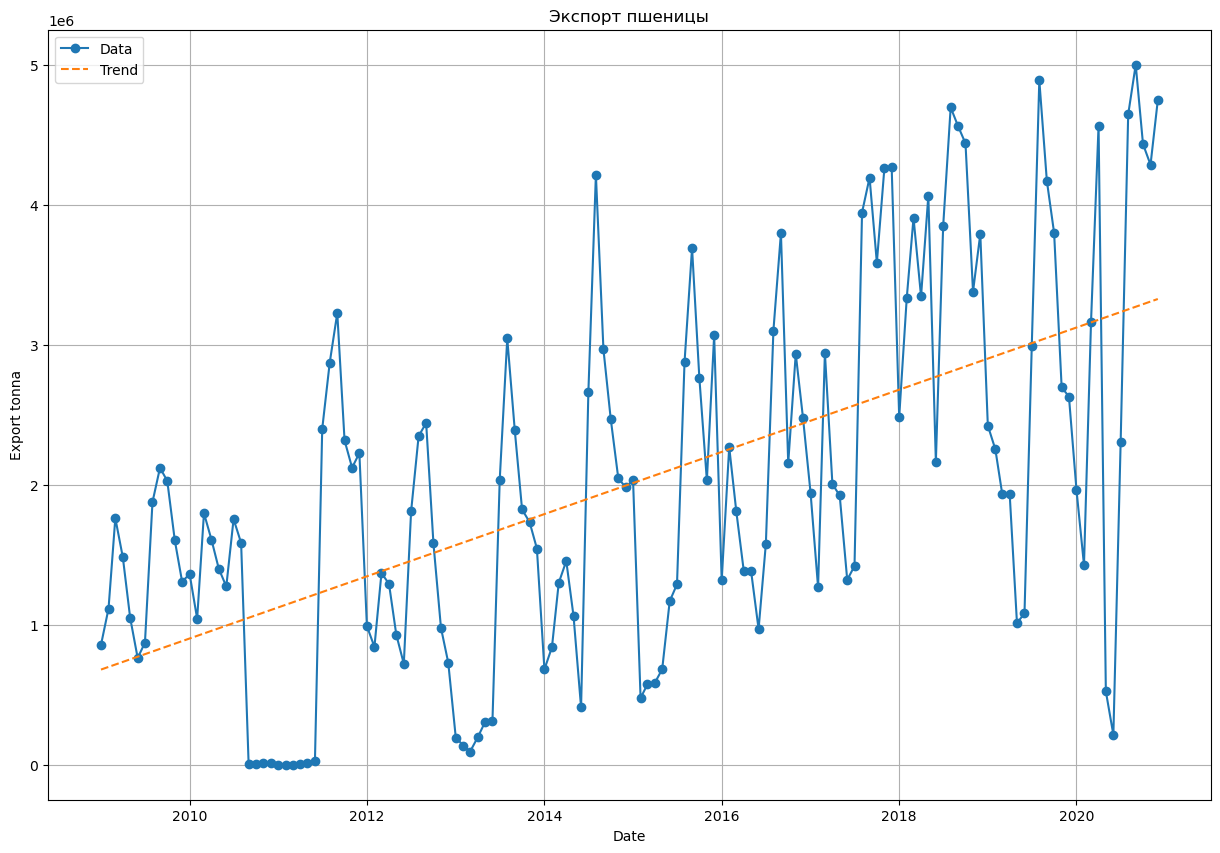

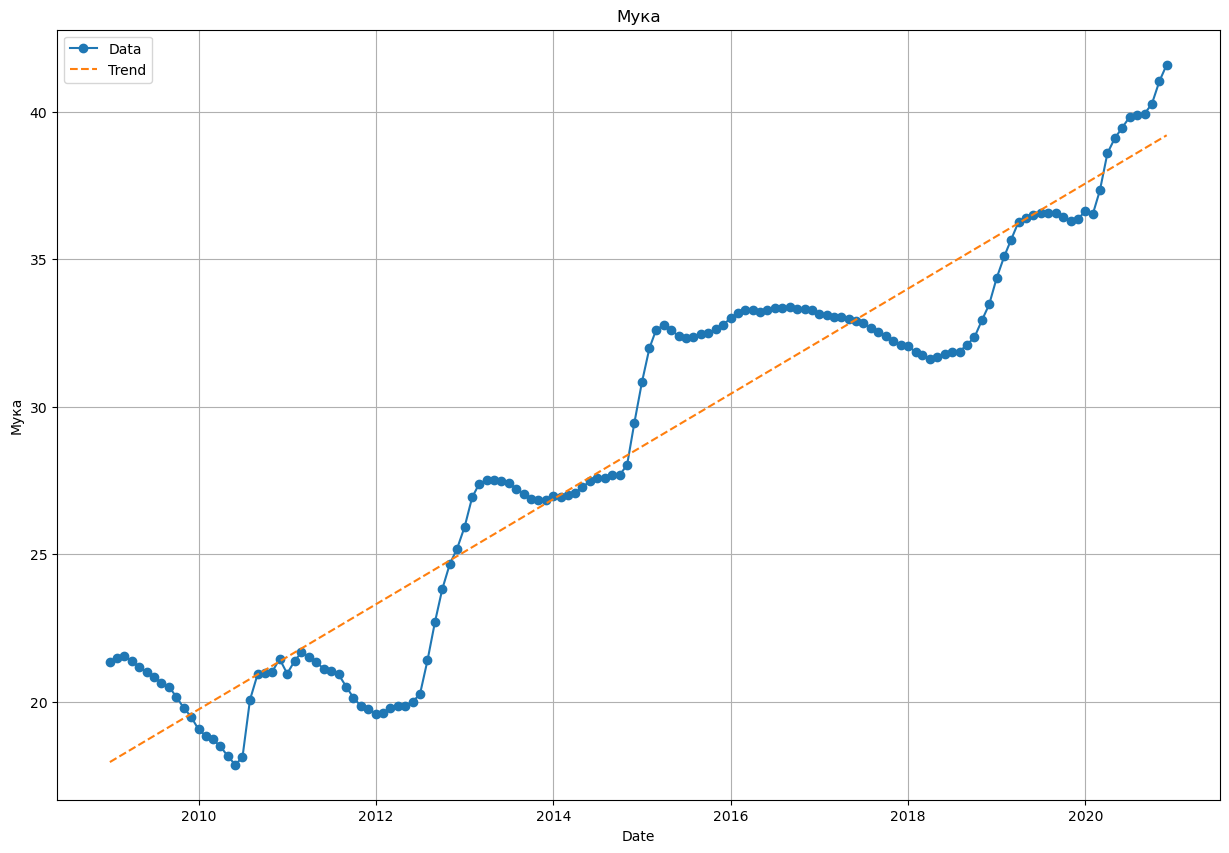

In [12]:
def plot_with_trend(x, y, title, ylabel):
    plt.figure(figsize=(15, 10))
    plt.plot(x, y, label='Data', marker='o')

    # Преобразование дат в числовой формат (количество дней с начала периода)
    x_numerical = (x - x.min()).dt.days

    # Построение линейного тренда
    z = np.polyfit(x_numerical, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x_numerical), label='Trend', linestyle='--')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Построение графиков для каждой переменной
plot_with_trend(data['Date'], data['Export tonna'], 'Экспорт пшеницы', 'Export tonna')
plot_with_trend(data['Date'], data['Muka'], 'Мука', 'Мука')
# plot_with_trend(data['Date'], data['Makar'], 'Макароны', 'Макароны')
# plot_with_trend(data['Date'], data['Price'], 'Price by Year', 'Price')

Рассмотрим график ежемесячного изменения цены на муку в России с 2009 год по 2020.
Если есть какая-то тенденция, развивающаяся с течением времени, то это линейный трен (и нестационарный ряд)д. Его мы можем рассмотреть на графике. Получить формальный ответ, является ли этот ряд нестационарным мы можем с помощью теста Дики-Фуллера


In [14]:
ts01 = data['Muka']

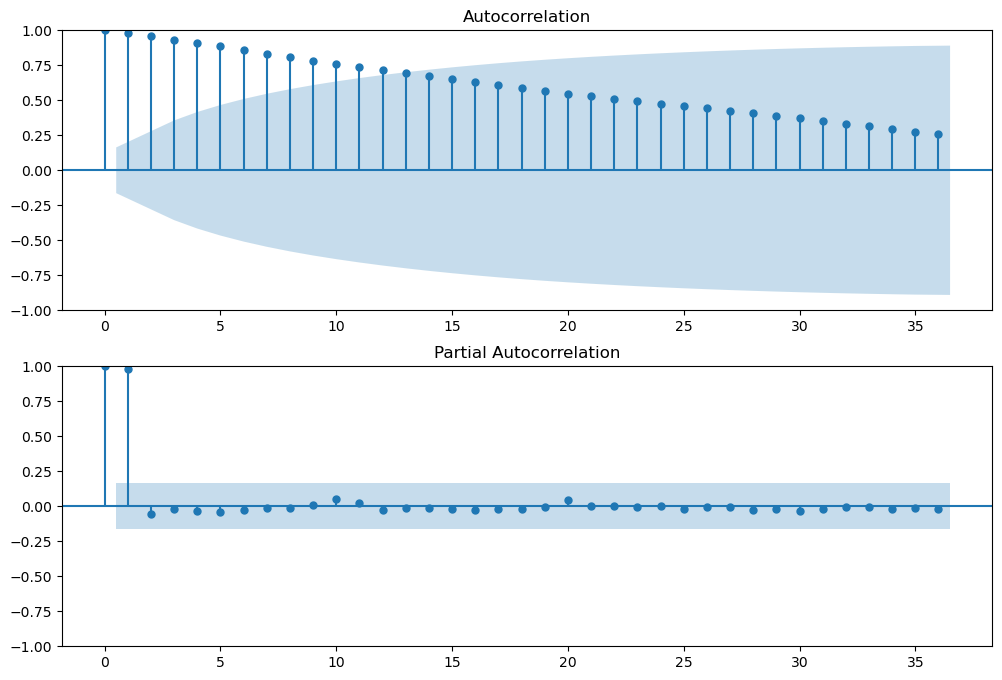

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts01.dropna(),lags=36,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts01.dropna(),lags=36, ax = ax2)

In [16]:
# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(ts01.diff().dropna(),lags=36,ax = ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(ts01.diff().dropna(),lags=36, ax = ax2)


У нестационарных процессов выборочные автокорреляции убывают медленно с ростом лага, а частная автокорреляционная функция почти равна 1 на первом лаге и далее почти равна 0, тогда ряд содержит единичные корни.  Для проверки нужно провести тест Дики-Фуллера, а затем проверить гипотезу о наличии единичного корня. Если p-value > 0.05 => гипотеза H0 о наличии единичного корня не отвергается => исходный временной ряд нестационарный


In [18]:
result = adfuller(ts01)

print('Результат теста Дики-Фуллера:')
print('Статистика теста:', result[0])
print('p-value:', result[1])
print('Лаги:', result[2])
print('Критические значения:', result[4])

if result[1] <= 0.05:
    print('Ряд является стационарным')
else:
    print('Ряд имеет тренд и/или константу')

Результат теста Дики-Фуллера:
Статистика теста: 0.17122005858130318
p-value: 0.9706004252218436
Лаги: 2
Критические значения: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
Ряд имеет тренд и/или константу


Результат расширенного теста Дики-Фуллера не отвергает гипотезу (p-value =0.97), а значит ряд нестационарный.  Тесты КПСС а также Филиппса-Перрона также говорят о нестационарности ряда. 

Тест KPSS отвергает нулевую гипотезу о стационарности ряда
 p-value < 0.01

In [21]:
smts_stats.kpss(ts01, regression='c')

C:\Users\mails\AppData\Local\Temp\ipykernel_65704\3387371148.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  smts_stats.kpss(ts01, regression='c')


(1.5914355087009096,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [22]:
adfuller(ts01.diff().dropna()) 

(-5.144128369943904,
 1.1420398747663653e-05,
 1,
 141,
 {'1%': -3.4776006742422374,
  '5%': -2.882265832283648,
  '10%': -2.5778219289774156},
 61.87046122814331)

In [23]:
smts_stats.kpss(ts01.diff().dropna(), regression='c')

C:\Users\mails\AppData\Local\Temp\ipykernel_65704\2122306346.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  smts_stats.kpss(ts01.diff().dropna(), regression='c')


(0.15373360820746446,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [24]:
import arch.unitroot as ar
ar.ADF(ts01.diff().dropna()).summary()

Test Statistic,-5.144
P-value,0.000
Lags,1


In [25]:
ar.PhillipsPerron(ts01.diff().dropna()).summary()

Test Statistic,-4.492
P-value,0.000
Lags,14


Тест Льюнг-Бокса (на проверку белошумности временного ряда) - критерий для выявления автокоррелированности временных рядов. Гипотеза отвергается, поскольку p-значение меньше 0.05, мы можем отвергнуть нулевую гипотезу о том, что нет автокорреляции. Это означает, что автокорреляции в ряде значимы.

In [27]:
sm.stats.diagnostic.acorr_ljungbox(ts01, lags=None)

,lb_stat,lb_pvalue
1,141.028423,1.586087e-32
2,276.599549,8.653088e-61
3,406.671055,7.945627e-88
4,531.042655,1.292066e-113
5,649.477823,4.105372e-138
6,761.880888,2.646254e-161
7,868.333201,3.302997e-183
8,968.988482,7.365992e-204
9,1064.179152,2.480827e-223
10,1154.633668,8.768888e-242


In [28]:
# считаем что такой продукт как  мука не является сезонным продуктом и его цена не зависит от времени года

In [29]:
adfuller(ts01.diff().diff().dropna()) 

(-7.624321235927369,
 2.088146905107245e-11,
 4,
 137,
 {'1%': -3.479007355368944,
  '5%': -2.8828782366015093,
  '10%': -2.5781488587564603},
 79.28765979945413)

Берется необходимое число последовательностей разностей через операцию дифференцирования для того, чтобы привести временной ряд к стационарному виду. Проверяем с помощью теста Дики-Фуллера ряд, полученный взятием первой разности. Результат теста сообщает о стационарности ряда, когда p-value < 0.05. Тест Дики-Фуллера подтверждает стационарность после взятия первой разности (p-value =1.14e-5).

In [31]:
ts1 = ts01.diff().dropna()

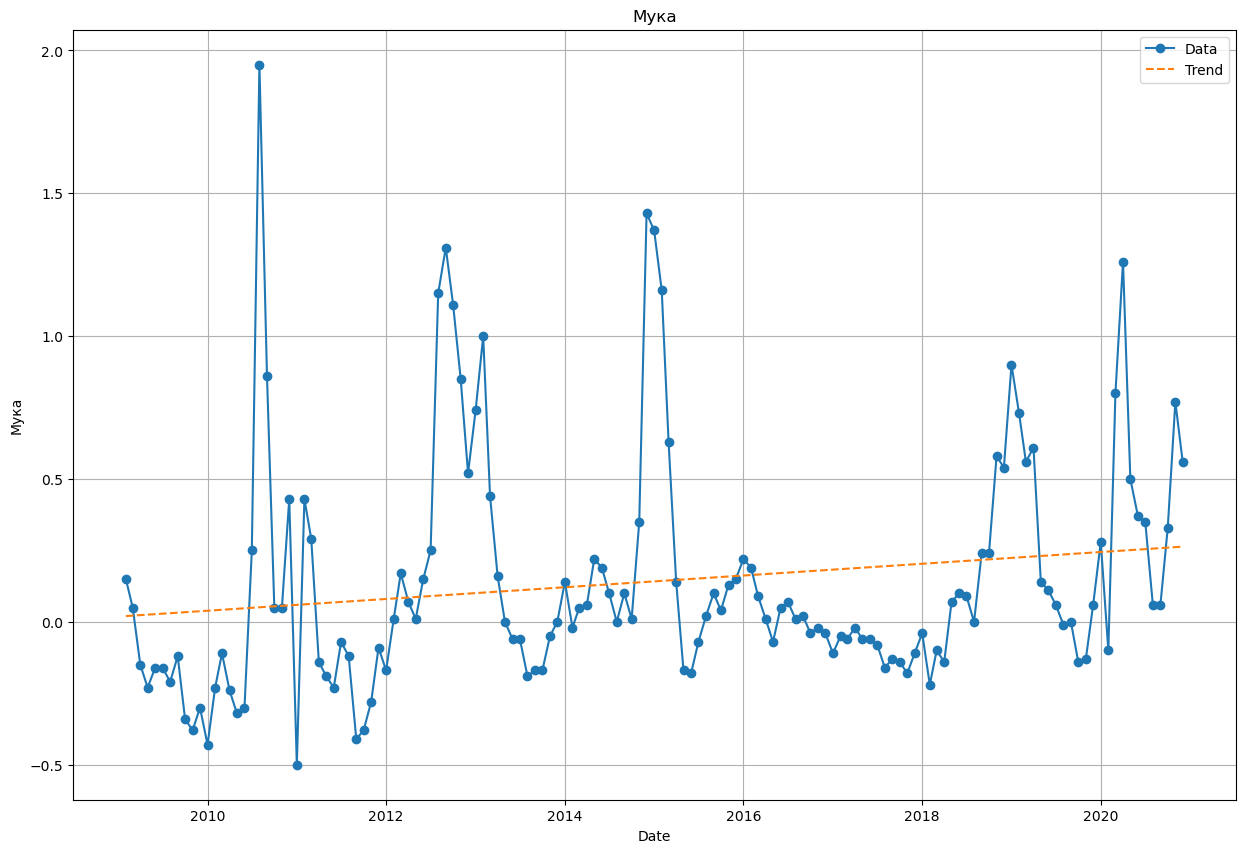

In [32]:
plot_with_trend(data['Date'][1:], ts01.diff().dropna(), 'Мука', 'Мука')

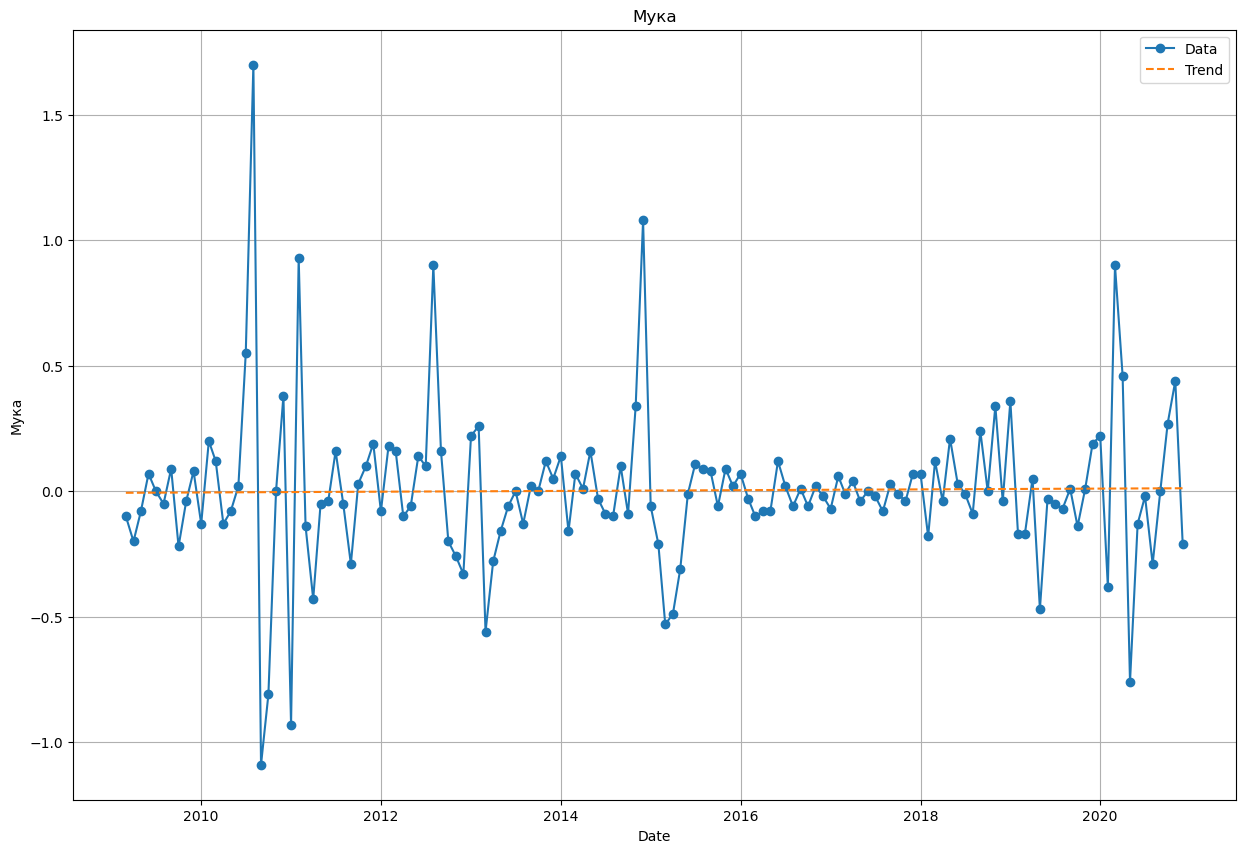

In [33]:
plot_with_trend(data['Date'][2:], ts1.diff().dropna(), 'Мука', 'Мука')

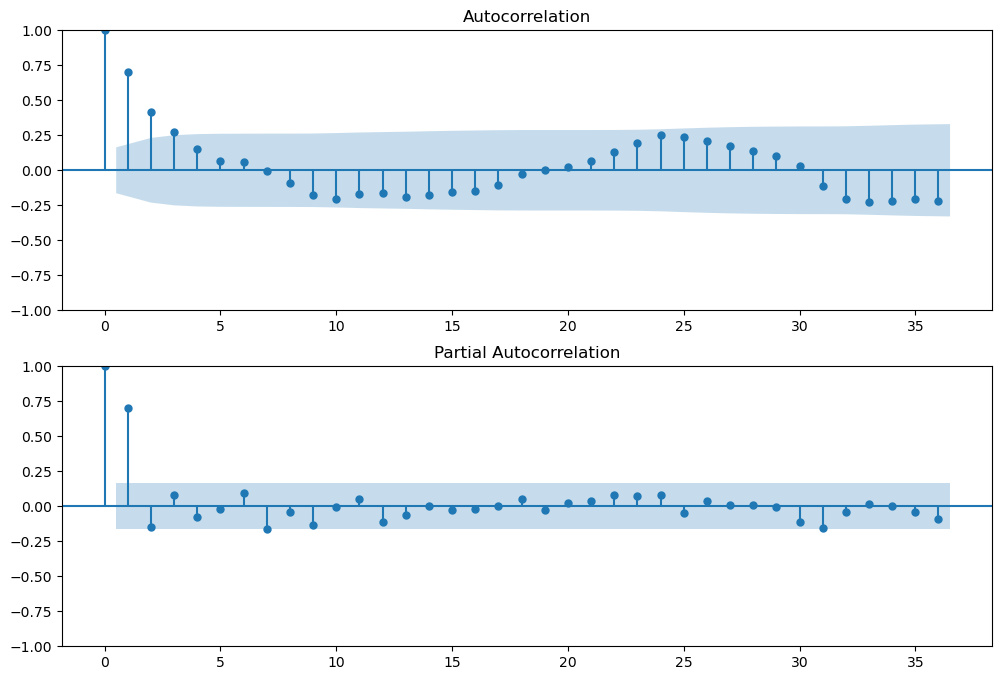

In [34]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts1.dropna(),lags=36,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts1.dropna(),lags=36, ax = ax2)

При анализе коррелограмм выдвигаются предположения о параметрах p и q. По графику автокорреляционной функции видно, что параметр скользящего среднего q равен 4 (поскольку значение автокорреляционной функции становятся статически незначимо отличными от нуля начиная с 5 лага), а по графику частной автокорреляционной функции предположим, что параметр p, являющимся порядком авторегрессии, равен 2.

Следовательно полученная модель ARIMA(2,1,4) with drift.

Попробуем сделать автоматический подбор модели ARIMA. 

In [37]:
model = auto_arima(ts01, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60.020, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=157.028, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.580, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82.933, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=170.924, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=61.750, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=61.680, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=66.961, Time=2.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=60.743, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=63.678, Time=0.81 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=61.766, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.419 seconds


In [38]:
import itertools

import warnings
warnings.filterwarnings("ignore")

p = range(0,6)
d = range(1,2)
q = range(0,4)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = 70
for params in pdq:
    model_test = sm.tsa.ARIMA(ts01, order = params)
    result_test = model_test.fit()
    if result_test.aic < best_aic:
        best_pdq = params
        print(best_pdq, result_test.aic, result_test.bic)

(1, 1, 0) 62.57660073759499 68.5022899981148
(1, 1, 1) 61.76570395603534 70.65423784681506
(1, 1, 2) 63.02154445383732 74.87292297487696
(1, 1, 3) 65.00923048320502 79.82345363450455
(2, 1, 0) 62.47402525979897 71.36255915057869
(2, 1, 1) 63.29077063744777 75.1421491584874
(2, 1, 2) 65.01687204395472 79.83109519525425
(2, 1, 3) 64.91073634747883 82.68780412903827
(3, 1, 0) 63.09922101144044 74.95059953248007
(3, 1, 1) 64.84886540478377 79.66308855608331
(3, 1, 2) 62.32583524459206 80.1029030261515
(3, 1, 3) 64.31236881187209 85.05228122369144
(4, 1, 0) 64.63849263586894 79.45271578716847
(4, 1, 1) 66.63795490159538 84.41502268315482
(4, 1, 2) 64.30828180996264 85.04819422178198
(4, 1, 3) 66.32583463351854 90.0285916755978
(5, 1, 0) 66.63566616836744 84.41273394992689
(5, 1, 1) 66.61370120110843 87.35361361292777
(5, 1, 2) 66.013833886221 89.71659092830023
(5, 1, 3) 67.81281983456485 94.47842150690401


In [39]:
# подобранная по графикам модель
model = sm.tsa.ARIMA(ts01, order=(2,1,4), freq='MS') 
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   Muka   No. Observations:                  144
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 -25.586
Date:                Mon, 02 Sep 2024   AIC                             65.171
Time:                        21:26:38   BIC                             85.911
Sample:                    01-01-2009   HQIC                            73.599
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1654      0.278     -0.596      0.551      -0.710       0.379
ar.L2         -0.0232      0.299     -0.078      0.938      -0.609       0.562
ma.L1          1.0394      0.281      3.702      0.0

In [40]:
# автоматичсеки подобранная
model = sm.tsa.ARIMA(ts01, order=(1,1,1), freq='MS') 
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   Muka   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -27.883
Date:                Mon, 02 Sep 2024   AIC                             61.766
Time:                        21:26:38   BIC                             70.654
Sample:                    01-01-2009   HQIC                            65.378
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6341      0.087      7.248      0.000       0.463       0.806
ma.L1          0.2161      0.090      2.415      0.016       0.041       0.392
sigma2         0.0860      0.004     20.213      0.0

Тест Харке-Бера отвергает гипотезу о нормальном распределении остатков (p-value =0.0), скорее всего из-за наличия выбросов во временном ряду вследствие экономических кризисов в некоторых годах.  На графике остатков нет явно выраженного повышения амплитуды колебания, а значит остатки можно считать гомоскедастичными.

In [42]:
sm.stats.jarque_bera(result.resid)

(107237.02135667065, 0.0, 11.41639606948432, 134.72509440466192)

In [43]:
sm.stats.diagnostic.acorr_ljungbox(result.resid)

,lb_stat,lb_pvalue
1,0.002356,0.961291
2,0.008280,0.995869
3,0.018860,0.999315
4,0.024390,0.999926
5,0.028832,0.999993
6,0.029263,0.999999
7,0.036817,1.000000
8,0.037225,1.000000
9,0.081146,1.000000
10,0.096717,1.000000


<Axes: xlabel='Date'>

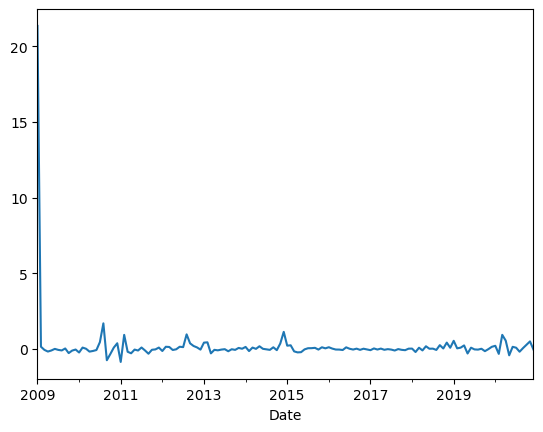

In [44]:
result.resid.plot()

Результат теста Бройша-Годфри не отвергает гипотезу о неавтокоррелированности остатков модели ARIMA(1,1,1) with drift (p_value = 0,95).

In [46]:
sm.stats.acorr_breusch_godfrey(result, nlags=1)

(0.0033274069371174164,
 0.9540005935303356,
 0.0032812687720974744,
 0.9544007979283138)

<Axes: xlabel='Date'>

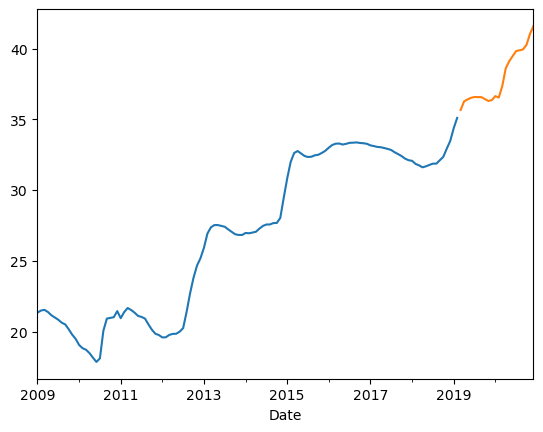

In [47]:
#divide into train and validation set
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]

#plotting the data
train['Muka'].plot()
test['Muka'].plot()

In [48]:
model = sm.tsa.ARIMA(train['Muka'], order=(1,1,1), freq='MS') # вставьте свои числа вместо p, d и q
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Muka   No. Observations:                  122
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -22.452
Date:                Mon, 02 Sep 2024   AIC                             50.904
Time:                        21:26:39   BIC                             59.291
Sample:                    01-01-2009   HQIC                            54.310
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6453      0.093      6.927      0.000       0.463       0.828
ma.L1          0.2017      0.096      2.108      0.035       0.014       0.389
sigma2         0.0843      0.004     19.717      0.000       0.076       0.093
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               713.34
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             2.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Псевдовневыборочный прогноз модели ARIMA(1,1,1) with drift, визуализированный на графике ниже, показал адекватный результат. Средняя абсолютная процентная ошибка прогнозирования MAPE равна 3,98%.

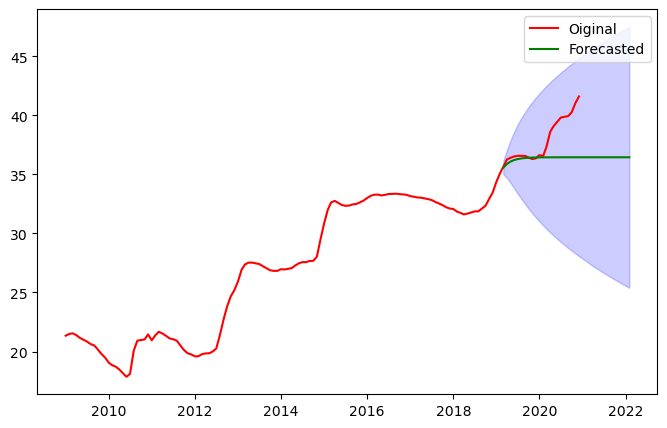

In [50]:
#Checking prediction value with test
forecast = result.get_forecast(steps=36)
mean = forecast.predicted_mean
conf_int = forecast.conf_int()
d = mean.index
plt.figure(figsize=(8,5))
# Plot past  levels
plt.plot(data.index, ts01, label='Oiginal', color = 'red')
# Prediction Mean
plt.plot(d, mean, label='Forecasted', color= 'green')
# Shade of space between  confidence intervals
plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2, color= 'blue')
# Plot legend 
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import r2_score

predictions = result.get_forecast(steps=len(test)).predicted_mean
print('R2score is',r2_score(test['Muka'], predictions))
mean_absolute_percentage_error = np.mean(np.abs(predictions - test['Muka'])/np.abs(test['Muka']))*100
print('MAPE is', mean_absolute_percentage_error)

R2score is -0.632164307026547
MAPE is 3.9759733940588537


In [52]:
result.get_forecast(steps=20).predicted_mean

2019-03-01    35.579416
2019-04-01    35.888796
2019-05-01    36.088448
2019-06-01    36.217288
2019-07-01    36.300432
2019-08-01    36.354087
2019-09-01    36.388712
2019-10-01    36.411057
2019-11-01    36.425476
2019-12-01    36.434782
2020-01-01    36.440787
2020-02-01    36.444662
2020-03-01    36.447163
2020-04-01    36.448776
2020-05-01    36.449818
2020-06-01    36.450490
2020-07-01    36.450924
2020-08-01    36.451203
2020-09-01    36.451384
2020-10-01    36.451501
Freq: MS, Name: predicted_mean, dtype: float64